<a href="https://colab.research.google.com/github/janwaelty/Bachelor-Thesis/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Neural Networks and the Art Market: A Deep Learning Approach to Valuation
#   **Numerical-features-only model**

**1. Library and data import**

In [99]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



drive.mount('/content/drive')
artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
artwork_numeric_data = pd.read_excel(artist_data_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Data preprocessing**

In [100]:
def repeated_to_single_transactions(df):
    """
    Transforms a dataset by splitting purchase and sale data into separate rows
    and renaming columns for consistency.
    """
    # Columns to keep (common info)
    common_columns = ['category', 'artist', 'height', 'width', 'medium']

    # Sale Data: Keep only relevant columns
    sale_data = df[common_columns + ['sale_year_semi', 'sale_price',
                                     'sale_house']].copy()
    sale_data = sale_data.rename(columns={
        'sale_year_semi': 'transaction_year_semi',
        'sale_price': 'transaction_price',
        'sale_house': 'transaction_house'
    })


    # Purchase Data: Keep only relevant columns
    purchase_data = df[common_columns + ['purchase_year_semi', 'purchase_price',
                                         'purchase_house']].copy()
    purchase_data = purchase_data.rename(columns={
        'purchase_year_semi': 'transaction_year_semi',
        'purchase_price': 'transaction_price',
        'purchase_house': 'transaction_house'
    })

    final_df = pd.concat([sale_data, purchase_data], ignore_index=True)

    return final_df


def one_hot(data, vars):
  # one-hot encoding for various categorical variables
  df = data.copy()
  return pd.get_dummies(df, columns=vars).astype(int)


def select_cols(data, vars, min_price=1000):
    """
    Remove entries with missing values, change prices to log scale,
    exclude transactions with prices below a specified threshold,
    and return selected columns.

    Parameters:
    - data: the original DataFrame
    - vars: list of columns to select
    - min_price: minimum price threshold (default is 1000)


    """
    df = data.copy()

    # Remove rows with missing values
    df.dropna(axis=0, how='any', inplace=True)

    # Filter out rows with transaction_price below the min_price threshold
    df = df[df['transaction_price'] >= min_price]



    return df[vars]



In [58]:
# check transformations

#print(artwork_numeric_data.columns)

cols = ['category', 'sale_year_semi', 'sale_price', 'artist',
        'purchase_year_semi', 'purchase_price', 'height', 'width',
        'medium', 'sale_house', 'purchase_house']

data_check = select_cols(artwork_numeric_data.copy(), cols)
#print(data_check.columns)
#print(data_check.head())

data_check = repeated_to_single_transactions(data_check)
#print(data_check)
#print(data_check.head())




KeyError: 'transaction_price'

**3.Data distributions**


Minimum category occurence is 75
Minimum sale_year_semi occurence is 95


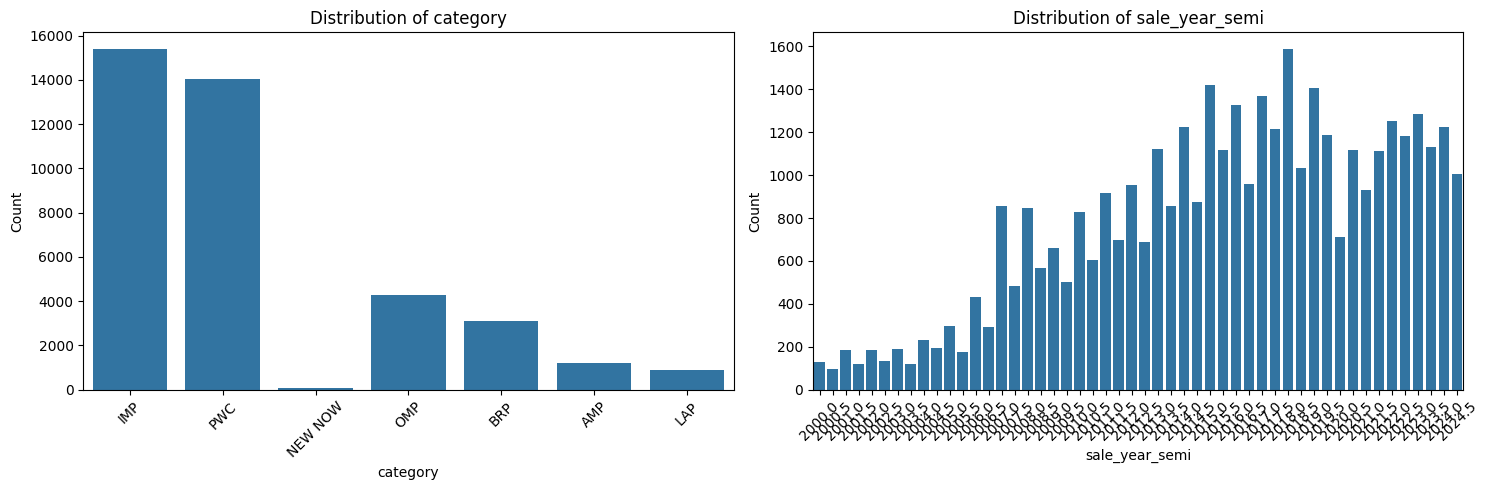

In [46]:
# List of categorical variables
categorical_columns = ['category', 'sale_year_semi']


# get minimum occurence per variable
for idx, var in enumerate(categorical_columns):
  counts = artwork_numeric_data[var].value_counts()
  print(f"Minimum {var} occurence is {min(counts)}")



# visualize distribution of categorical variables
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(15, 5))


for i, column in enumerate(categorical_columns):
    ax = axes[i]
    sns.countplot(x=column, data=artwork_numeric_data, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()




**4. Data split**

In [101]:
def data_split(df):
    """
    Splits the dataset into training and testing sets based on the last semi-year.

    Parameters:
    df (pd.DataFrame): DataFrame with transaction data, including 'transaction_year_semi' and 'transaction_price' and dummy columns.

    Returns:
    X_train, X_test, y_train, y_test: Features and target variables for training and testing.
    """


    # Identify the most recent dummy column (for the most recent semi-year)
    last_semi_year_col = df.columns[-1]  # Last column corresponds to the most recent semi-year

    # Split the data into training and testing sets based on the most recent semi-year
    train_data = df[df[last_semi_year_col] == 0]  # Train set (those where the dummy is 0)
    test_data = df[df[last_semi_year_col] == 1]   # Test set (those where the dummy is 1)

    # Prepare X and y for both training and testing
    X_train = train_data.drop(columns='transaction_price')
    y_train = np.log(train_data['transaction_price'])

    X_test = test_data.drop(columns='transaction_price')
    y_test = np.log(test_data['transaction_price'])

    # Ensure both X_train and X_test have the same columns (after dummy creation)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Specify numerical features that need scaling
    numerical_features = ['height', 'width']

    # Apply standardization to numerical features
    X_train, X_test = standardization(X_train, X_test, numerical_features)

    return X_train, X_test, y_train, y_test


def standardization(train, test, numerical_features):

    scaler = StandardScaler()
    train[numerical_features] = scaler.fit_transform(train[numerical_features])
    test[numerical_features] = scaler.transform(test[numerical_features])

    return train, test


def get_data_for_nn(data, selected_vars, dummy_vars):
    """
    Returns data in correct format for NN
    Params: data set, predictors and target, categorical variables for one-hot
            encoding
    """
    df = data.copy()
    # Select the columns from the DataFrame

    # Get single transaction format and one-hot encode the categorical variables
    df = repeated_to_single_transactions(df)
    df = select_cols(df, selected_vars)
    df = one_hot(df, dummy_vars)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = data_split(df)

    return X_train, X_test, y_train, y_test


check = repeated_to_single_transactions(artwork_numeric_data)
check = select_cols(check, selected_vars)
check = one_hot(check, one_hot_vars)






**5. Model training**

In [102]:
class Numerical_Model(nn.Module):

    def __init__(self, in_features, h1, h2, h3,  out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2, h3)
        self.relu = nn.ReLU()
        self.out = nn.Linear(h3, out_features)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.out(x)
        return x



def train(network, trainloader, testloader, epochs=100, eta=0.0001, momentum=0.9):
    optimizer = torch.optim.SGD(params=network.parameters(), lr=eta, momentum=momentum)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)
    loss = torch.nn.MSELoss()
    val_loss = []

    for epoch in range(epochs):
        # Initialize the total loss for train and test data
        J_train = 0
        total_train_samples = 0  # Counter for number of train samples

        # Train the network on training data
        for x, t in trainloader:
            network.train()
            optimizer.zero_grad()
            x, t = x.to(device), t.to(device)

            # Make a forward pass
            z = network(x)

            # Reshape target to (batch_size, 1)
            t = t.view(-1, 1)  # Ensure target is the same shape as output

            J = loss(z, t)  # Compute the loss
            J_train += J.item() * x.size(0)  # Multiply by the number of samples in the batch
            total_train_samples += x.size(0)  # Count the number of samples

            J.backward()
            optimizer.step()

        # Compute the average train loss
        avg_train_loss = J_train / total_train_samples

        # Test on validation data
        J_test = 0
        total_test_samples = 0  # Counter for number of test samples
        with torch.no_grad():
            network.eval()
            for x, t in testloader:
                x, t = x.to(device), t.to(device)
                z = network(x)

                t = t.view(-1, 1)  # Reshape target for test set
                J_test += loss(z, t).item() * t.size(0)
                total_test_samples += t.size(0)

        # Compute the average test loss
        avg_test_loss = J_test / total_test_samples


        # Print train and test loss for each epoch
        print(f'Epoch [{epoch + 1}/{epochs}]',
              f'Train loss: {avg_train_loss:.6f}',
              f'Test loss: {avg_test_loss:.6f}')

    # save predictions and targets after last epoch
    pred, target = [],[]
    with torch.no_grad():
      network.eval()
      for x, t in testloader:
        prediction = network(x.to(device))
        # Ensure correct shape
        pred.extend(prediction.view(-1).detach().cpu().numpy())
        target.extend(t.view(-1).detach().cpu().numpy())  # Flatten t as well


    return network, pred, target




In [103]:
# training phase

class TransactionDataset(Dataset):

    def __init__(self, X, y):
        # Ensure that all values are numeric and convert to numpy arrays of correct dtype
        self.X = X.reset_index(drop=True).values.astype('float32')  # Ensure float32 type
        self.y = y.reset_index(drop=True).values.astype('float32')  # Ensure float32 type

    def __len__(self):
        # Return the total number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Fetch one sample by index
        x_sample = self.X[idx]
        y_sample = self.y[idx]
        return torch.tensor(x_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)

def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
    # Create the training dataset and dataloader
    train_dataset = TransactionDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Create the testing dataset and dataloader
    test_dataset = TransactionDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader



selected_vars =  ['category', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house',
                  'transaction_year_semi',]
one_hot_vars = ['category', 'artist', 'medium', 'transaction_house',
                 'transaction_year_semi']


X_train, X_test, y_train, y_test = get_data_for_nn(artwork_numeric_data,
                                                   selected_vars,
                                                   one_hot_vars)


trainloader, testloader = create_dataloaders(X_train, X_test, y_train, y_test)


In [104]:

# Initialize the model with the correct number of input features
model = Numerical_Model(in_features=X_train.shape[1], h1=64, h2=32, h3=16)

# Train the model
NumericalModel, prediction_numerical_model, target = train(model, trainloader,
                                                           testloader,
                                                           eta = 0.00004,
                                                           epochs = 10)

Epoch [1/10] Train loss: 14.515335 Test loss: 2.858291
Epoch [2/10] Train loss: 2.537219 Test loss: 2.783399
Epoch [3/10] Train loss: 2.474031 Test loss: 2.842857
Epoch [4/10] Train loss: 2.342416 Test loss: 2.707949
Epoch [5/10] Train loss: 2.155595 Test loss: 2.634883
Epoch [6/10] Train loss: 2.001332 Test loss: 2.462856
Epoch [7/10] Train loss: 1.937927 Test loss: 2.454477
Epoch [8/10] Train loss: 1.705206 Test loss: 2.197843
Epoch [9/10] Train loss: 1.963174 Test loss: 2.503490
Epoch [10/10] Train loss: 1.769193 Test loss: 2.154133


In [72]:
# small set checks
print(f"Total test batches: {len(testloader)}")
print(f"Total test samples: {len(y_test)}")
print(f"Test data shape : {X_test.shape}")
print(f"Train data shape : {X_train.shape}")


Total test batches: 32
Total test samples: 1003
Test data shape : (1003, 1275)
Train data shape : (76751, 1275)


R-squared: 0.3046042340090095


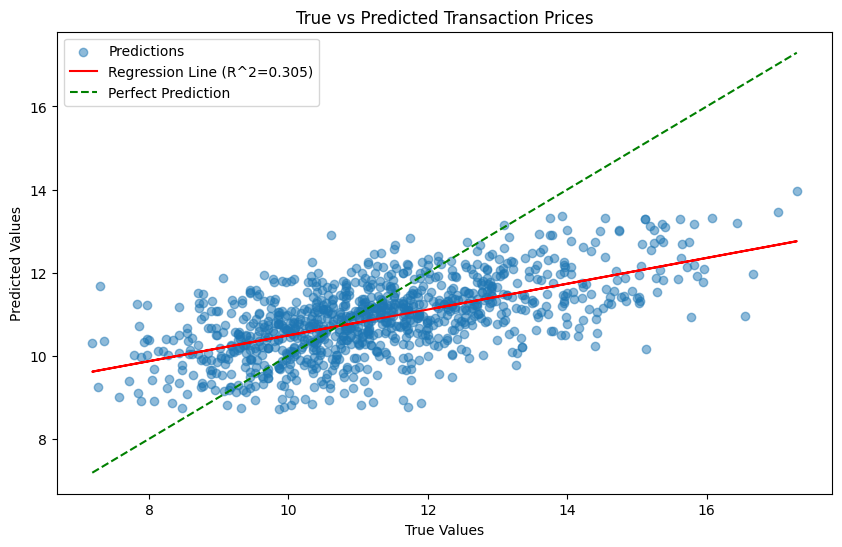

0.3105762146760802


In [105]:
from scipy.stats import linregress
from sklearn.metrics import r2_score

# Assuming 'target' and 'prediction_numerical_model' are lists or arrays containing the true and predicted values
# Ensure target and predictions are numpy arrays of the correct type
target = np.array(target, dtype=np.float64)
prediction_numerical_model = np.array(prediction_numerical_model, dtype=np.float64)

# Compute R-squared using sklearn
r_squared = r2_score(target, prediction_numerical_model)
print(f"R-squared: {r_squared}")

# Compute regression line parameters using linregress
slope, intercept, r_value, p_value, std_err = linregress(target, prediction_numerical_model)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(target, prediction_numerical_model, alpha=0.5, label='Predictions')


# Plot the regression line
plt.plot(target, slope * target + intercept, color='red', label=f'Regression Line (R^2={r_squared:.3f})')

# Plot y=x line (perfect predictions)
plt.plot([min(target), max(target)], [min(target), max(target)], color='green', linestyle='--', label='Perfect Prediction')

# Labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Transaction Prices')
plt.legend()

# Show the plot
plt.show()

print(slope)

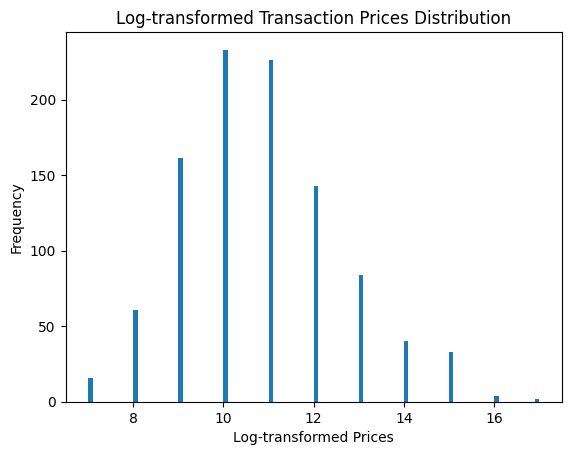

In [98]:
# Histogram of log-transformed transaction prices

plt.hist(y_test, bins=100)
plt.title('Log-transformed Transaction Prices Distribution')
plt.xlabel('Log-transformed Prices')
plt.ylabel('Frequency')
plt.show()